# Movie Genre Trends on IMDB over the years

## Preparing the dataset

IMDB datasets: https://www.imdb.com/interfaces/. Chosen datasets: *title.basics.tsv.gz* and *title.ratings.tsv.gz*. 

The created dataset is called *movie_data_single_genre*, and can be directly downloaded from here https://drive.google.com/file/d/1FeYNXyVxjiIxYYkywCJ_jk6Lt7sefpnX/view?usp=sharing 

No need to run this section if you download the data.

In [279]:
# used libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy
from sklearn.metrics import r2_score

In [278]:
# reading the chosen datasets, filtering and merging them into a new dataset
movie_general_data = pd.read_table('../data/general_data.tsv', delimiter='\t', usecols=['tconst','titleType', 'primaryTitle','genres', 'startYear'], dtype={'tconst':str,'titleType': str, 'primaryTitle':str, 'genres':object, 'startYear': object})
movie_rating_data = pd.read_table('../data/rating_data.tsv', delimiter='\t', usecols=['tconst','averageRating','numVotes'], dtype={'tconst':str,'averageRating':float, 'numVotes': int})
movie_data = pd.merge(movie_general_data, movie_rating_data, on='tconst', how='inner')

movie_data.query(expr = "titleType == 'movie'", inplace= True)

movie_data.drop(columns = ['tconst', 'titleType'], inplace= True)
movie_data.reset_index(inplace = True, drop = True)

In [48]:
# removing null entries
movie_data.dropna(inplace=True, subset=['startYear', 'averageRating','numVotes'])

# some null values are marked as '\N' -> manually removing them 
null_string = '\\' + 'N'
movie_data.query(expr = 'genres != @null_string & startYear != @null_string', inplace= True)

# manually changing the datatype of the column
movie_data['startYear'] = movie_data['startYear'].astype(int) 

# splitting the list entries from genres column into separate entries
if isinstance(movie_data['genres'][0], str) :
    movie_data['genres'] = movie_data['genres'].map(lambda genre: genre.split(','))

movie_data_single_genre = movie_data.explode('genres', ignore_index= True)
movie_data_single_genre.index.name = 'id'

# print the obtained dataset to csv
movie_data_single_genre.to_csv('../data/movie_data_single_genre.csv') 

display(movie_data_single_genre.head(10))


,primaryTitle,startYear,genres,averageRating,numVotes
id,,,,,
0,Miss Jerry,1894,Romance,5.3,204
1,The Corbett-Fitzsimmons Fight,1897,Documentary,5.3,466
2,The Corbett-Fitzsimmons Fight,1897,News,5.3,466
3,The Corbett-Fitzsimmons Fight,1897,Sport,5.3,466
4,The Story of the Kelly Gang,1906,Action,6.0,820
5,The Story of the Kelly Gang,1906,Adventure,6.0,820
6,The Story of the Kelly Gang,1906,Biography,6.0,820
7,The Prodigal Son,1907,Drama,4.4,20
8,Robbery Under Arms,1907,Drama,4.3,24


## Analysis on a specific genre of movie

For analysis, we start with only one gere, Romance. To obtain relevant data on an yearly basis, a weighted average will be computed for each year. The *averageRating* will be the variables, and the *numVotes* will serve as the weights. This way, we obtain a more realisting indices on the quality of the movie.

In [109]:
# function for computing weighted average for a dataset using two columns
def weighted_average(dataframe, value, weight):
    val = dataframe[value]
    wt = dataframe[weight]
    weighted_rating = (val * wt).sum() / wt.sum()

    return weighted_rating

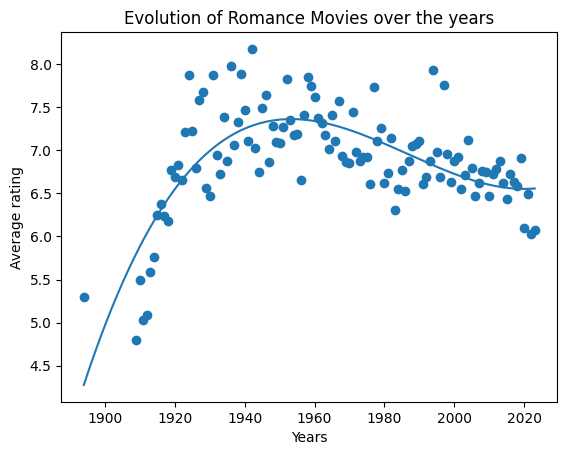

Coef of correlation:0.5340069370481637


In [49]:
# filter dataset for romance movies
romance = movie_data_single_genre.query(expr = "genres == 'Romance'")

# group by year of release and compute weighted average 
rating = romance.groupby('startYear').apply(weighted_average, 'averageRating', 'numVotes')

# prepare the training data
x = rating.index
y = rating.values

# compute teh model (polynomial regression)
mymodel = numpy.poly1d(numpy.polyfit(x, y, 3))
myline = numpy.linspace(x[0],x[x.size-1], 1000)

# plot the training data and the model together
plt.scatter(x, y)
plt.plot(myline, mymodel(myline))
plt.title('Evolution of Romance Movies over the years')
plt.xlabel('Years')
plt.ylabel('Average rating')
plt.show()

# the correlation coef
r = r2_score(y, mymodel(x))
print('Coef of correlation:{}'.format(r))

It can be seen that the coeficinet of correlation is close to 0.5, witch means we can make predicitions, but not moderately accurate ones. However, a conclusion that can be drawn is that the highest rated romance movies were released between 1940 and 1960. Some of which can be seen below.

In [50]:
display(romance.loc[(romance['startYear'] > 1940) & (romance['startYear']<1960)].nlargest(10, 'averageRating'))

,primaryTitle,startYear,genres,averageRating,numVotes
id,,,,,
46352,Meine 99 Bräute,1958,Romance,9.2,20
181206,Humsafar,1953,Romance,9.0,11
40264,Racing Blood,1954,Romance,8.9,17
206279,A Sinful Life,1957,Romance,8.7,9
35064,The Naked and the Wicked,1951,Romance,8.6,33
122924,The Counterfeit Coin,1955,Romance,8.6,2933
155503,Las campanas de Teresa,1957,Romance,8.6,11
165842,Do Sitare,1951,Romance,8.6,11
167368,Anakku Sazali,1956,Romance,8.6,77


## Prediction

Making a prediction for a year that does not have any romantic movies in the dataset. However, if the year is already whithin the dataset, its corresponding average rating will be displayed. 

In [300]:
year = 1907

if year in set(romance['startYear']):
    prediction = round(rating[year])
    print('The calculated average rating for a romantic movie from {} is {}.'.format(year, prediction)) 
else:
    prediction = round(mymodel(year), 1)
    print('The predicted average rating for a romantic movie from {} is {}.'.format(year, prediction))

The predicted average rating for a romantic movie from 1907 is 5.6.


## Application

A simple application for displaying evolution of a movie genre on IMDB. The application also provides some interpetation and insights. 
The user can chose between all the 28 movie genre from IMDB. The used dataset encapsulates data from 1910 until spring 2023. 

The dataset can be downloaded from : https://drive.google.com/file/d/1FeYNXyVxjiIxYYkywCJ_jk6Lt7sefpnX/view?usp=sharing. Please add the csv file to the *data* folder in this project.

Please choose a number between 1 and 28, each corresponding to a genre as follows: 
1. Adventure
2. Film-Noir
3. War
4. News
5. Action
6. Horror
7. Family
8. Musical
9. Western
10. Animation
11. Music
12. Short
13. Crime
14. Biography
15. Fantasy
16. Mystery
17. Thriller
18. Adult
19. Talk-Show
20. Romance
21. Game-Show
22. Sci-Fi
23. Comedy
24. Documentary
25. History
26. Reality-TV
27. Sport
28. Drama
You chose History


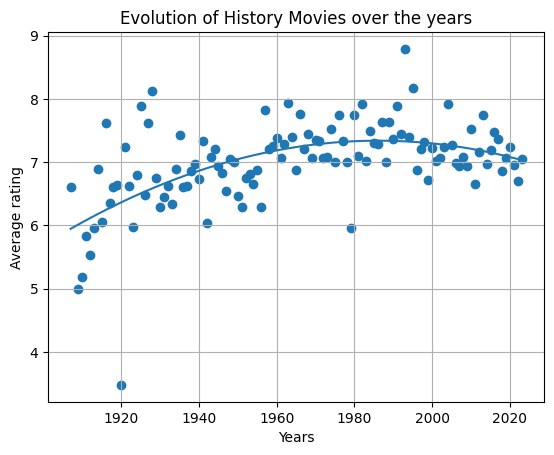

The correlance coefficinet is 0.32469627428710257
There is very low correlation between data, low accuracy predictions can be made.

Some facts resulted from your inquiry:
* The year with the highest average rating(8.8) for History movies is 1993.
* In the year 1993, 49 History movies were released, amongst which, the top 10 rated movies were:


,primaryTitle,startYear,genres,averageRating,numVotes
1,Schindler's List,1993,History,9.0,1372774
2,Supplì,1993,History,8.5,21
3,"The Wonderful, Horrible Life of Leni Riefenstahl",1993,History,8.1,2982
4,Sardar,1993,History,8.1,811
5,Perlasca,1993,History,8.1,42
6,The Last Bolshevik,1993,History,7.9,702
7,Tombstone,1993,History,7.8,153769
8,The History of the Wonderful World,1993,History,7.8,41
9,Gettysburg,1993,History,7.6,29921
10,The War Room,1993,History,7.4,4300


* Also, the top 5 movies with the most votes were:


,primaryTitle,startYear,genres,averageRating,numVotes
1,Schindler's List,1993,History,9.0,1372774
2,Tombstone,1993,History,7.8,153769
3,Gettysburg,1993,History,7.6,29921
4,Geronimo: An American Legend,1993,History,6.5,12398
5,King of the Hill,1993,History,7.3,8517


In [277]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from myfunctions import read_from_global_csv

# read necessary data
df = pd.read_csv('../data/movie_data_single_genre.csv', index_col='id' )
geners_list = read_from_global_csv('unique_geners_list', list)

# prompt the user for a genre of movie
print('Please choose a number between 1 and {}, each corresponding to a genre as follows: '.format(len(geners_list)))
for genre in geners_list:
    print('{}. {}'.format(geners_list.index(genre)+1, genre))

choice_id = int(input())

# get the genre chosen by the user
choice = geners_list[choice_id-1]
print('You chose {}'.format(choice))

# filter data for the chosen movie genre
snap = df.query(expr = "genres == @choice ")

# apply weighted average function to the rating and vote number columns, such that the rating's importance is directly proportionate to the number of votes
rating = snap.groupby('startYear').apply(weighted_average, 'averageRating', 'numVotes')

# prepare data for polynomial regression analysis
x = rating.index
y = rating.values

# polynomial regression for modelling the data
mymodel = numpy.poly1d(numpy.polyfit(x, y, 3))
myline = numpy.linspace(x[0],x[x.size-1], 100000)

# plot both the data used for obtaining the model and the model
plt.scatter(x,y)
plt.plot(myline, mymodel(myline))
plt.title('Evolution of {} Movies over the years'.format(choice))
plt.xlabel('Years')
plt.ylabel('Average rating')
plt.grid()
plt.show()

# compute correlation coef
r = r2_score(y, mymodel(x))

# Providing correlation related data and interpretation
print(f'The correlance coefficinet is {r}')

r = abs(r)

if r < 1:
    if r > 0.9:
        print('There is very high correlation between data, accurate predictions can be made.\n')
    elif r > 0.7:
        print('There is  high correlation between data, somewhat accurate predictions can be made.\n')
    elif r > 0.5:
        print('There is very moderate correlation between data, okay predictions can be made.\n')
    elif r > 0.3:
        print('There is very low correlation between data, low accuracy predictions can be made.\n')
    else:
        print('There is negligible  correlation between data, no predictions can be made.\n')

# Providing movie genre related insights
higest_rating_value = rating.max()
higest_rating_year = rating[rating == higest_rating_value].index[0]

higest_rating_movies = snap.query(expr = "startYear == @higest_rating_year ")

higest_rating_movies_counter = higest_rating_movies.count(axis= 'index')[0]

if higest_rating_movies_counter > 10:
    movies_to_display = 10
else:
    movies_to_display = higest_rating_movies_counter

# getting top rated movies from the respective year
top_movies_rating = higest_rating_movies.nlargest(movies_to_display, 'averageRating')
top_movies_rating.reset_index(inplace = True, drop = True)
top_movies_rating.index = range(1,len(top_movies_rating)+1)

top_movies_votes= higest_rating_movies.nlargest(round(movies_to_display/2), 'numVotes')
top_movies_votes.reset_index(inplace = True, drop = True)
top_movies_votes.index = range(1,len(top_movies_votes)+1)

# printing the resulted analysis to the user
print('Some facts resulted from your inquiry:')
print(f'* The year with the highest average rating({round(higest_rating_value,1)}) for {choice} movies is {higest_rating_year}.')
print(f'* In the year {higest_rating_year}, {higest_rating_movies_counter} {choice} movies were released, amongst which, the top {movies_to_display} rated movies were:')
display(top_movies_rating)
print(f'* Also, the top {round(movies_to_display/2)} movies with the most votes were:')
display(top_movies_votes)